# Imports

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
# Tensorflow
import tensorflow as tf
import tensorflow_datasets as tfds
# Sk learn
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder
from sklearn.model_selection import train_test_split

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data(
    path='boston_housing.npz', test_split=0.2, seed=113
)

57344/57026 [==============================] - 0s 0us/step


# Since data is already normalized and standardized we only need to make a model and fit it the data

In [ ]:
# Build a model

# Setup random seed
tf.random.set_seed(42)

# 1. Build the model
model_1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(126,activation="relu"),
    tf.keras.layers.Dense(60),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_1.compile(loss = tf.keras.losses.mae,
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["mae"])

# Early callback
callback = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=10)

# 3. Fit the model
history = model_1.fit(x_train,
                      y_train,
                      epochs = 1000,
                      callbacks = [callback],
                      verbose=0)

In [ ]:
# Plot history ( also known as a loss curve or a training curve)
def plot_history(history):
  pd.DataFrame(history.history).plot(figsize=(10,6))
  plt.ylabel("loss")
  plt.xlabel("epochs")
  plt.show()

# View Mae
def mae(y_true,y_pred):
  return tf.metrics.mean_absolute_error(y_true = y_true,
                                        y_pred = tf.squeeze(y_pred))
# View Mse
def mse(y_true,y_pred):
  return tf.metrics.mean_squared_error(y_true = y_true,
                                       y_pred = tf.squeeze(y_pred))

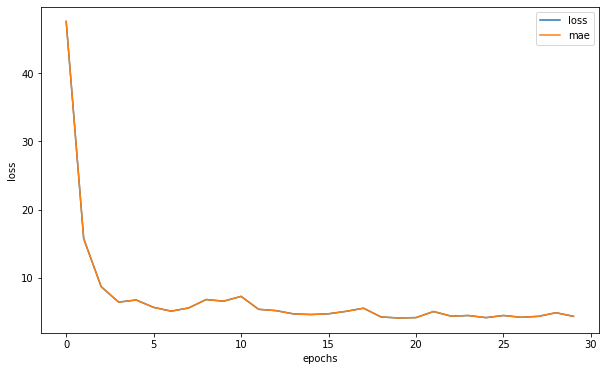

In [ ]:
plot_history(history)

In [ ]:
model_1.evaluate(x_test,y_test)

4/4 [==============================] - 0s 3ms/step - loss: 4.9499 - mae: 4.9499


[4.949896812438965, 4.949896812438965]

In [ ]:
y_pred = model_1.predict(x_test)
mae_1 = mae(y_test,y_pred)
mse_1 = mse(y_test,y_pred)

print("Mean absolute error: ",mae_1)
print("Mean squared error: ",mse_1)

Mean absolute error:  tf.Tensor(4.949897, shape=(), dtype=float32)
Mean squared error:  tf.Tensor(46.258533, shape=(), dtype=float32)


### Lets see if we can improve on this

In [ ]:
# Second model

# Random seed
tf.random.set_seed(42)

# 1. Build model 2
model_2 = tf.keras.Sequential([
    tf.keras.layers.Dense(512),
    tf.keras.layers.Dense(256),
    tf.keras.layers.Dense(126),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_2.compile(loss = tf.keras.losses.mae,
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["mae"])
# Callback
callback = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=10)

# 3. Fit the model
history_2 = model_2.fit(x_train,
              y_train,
              epochs=1000,
              verbose=0)

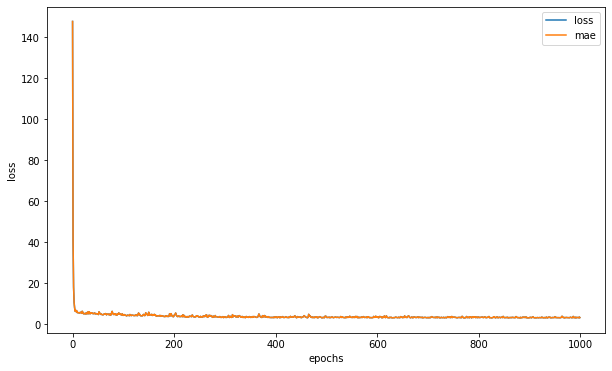

In [ ]:
plot_history(history_2)

In [ ]:
model_2.evaluate(x_test,y_test)

4/4 [==============================] - 0s 3ms/step - loss: 3.1779 - mae: 3.1779


[3.1779205799102783, 3.1779205799102783]

In [ ]:
y_pred_2 = model_2.predict(x_test)
mae_2 = mae(y_test,y_pred_2)
mse_2 = mse(y_test,y_pred_2)

print("Mean absolute error: ",mae_2)
print("Mean squared error: ",mse_2)

Mean absolute error:  tf.Tensor(3.1779206, shape=(), dtype=float32)
Mean squared error:  tf.Tensor(19.83533, shape=(), dtype=float32)


### Lets build another complex model such as model_2 but with relu activation on the first layers

In [ ]:
# Build model 3

# Set up random seed
tf.random.set_seed(42)

# 1. Build the model
model_3 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512,activation="relu"),
    tf.keras.layers.Dense(256,activation="relu"),
    tf.keras.layers.Dense(126,activation="relu"),
    tf.keras.layers.Dense(64,activation="relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
model_3.compile(loss = tf.keras.losses.mae,
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["mae"])

# Callback
callback = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=10)

# 3. Fit the model
history_3  = model_3.fit(x_train,
                         y_train,
                         epochs=1000,
                         callbacks = [callback],
                         verbose = 0)

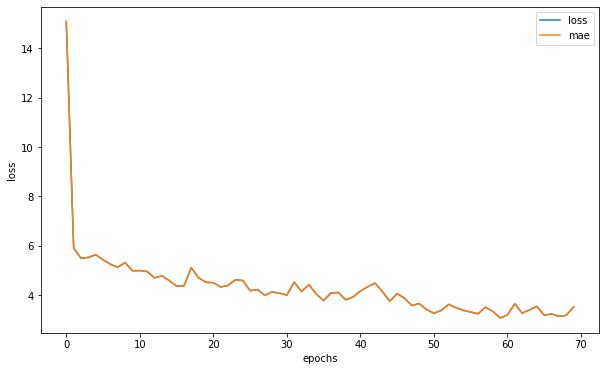

In [ ]:
plot_history(history_3)

In [ ]:
model_3.evaluate(x_test,y_test)

4/4 [==============================] - 0s 3ms/step - loss: 3.5338 - mae: 3.5338


[3.5338006019592285, 3.5338006019592285]

In [ ]:
y_pred_3 = model_3.predict(x_test)
mae_3 = mae(y_test,y_pred_3)
mse_3 = mse(y_test,y_pred_3)

print("Mean absolute error: ",mae_1)
print("Mean squared error: ",mse_1)

Mean absolute error:  tf.Tensor(4.949897, shape=(), dtype=float32)
Mean squared error:  tf.Tensor(46.258533, shape=(), dtype=float32)


## Build a model with keras tuner

In [ ]:
pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 5.5MB/s 


In [ ]:
import kerastuner as kt

# Function to build the models
def model_builder(hp):
  model = tf.keras.Sequential()
  hp_units = hp.Int('units',min_value=32,max_value=512,step=16)
  
  model.add(tf.keras.layers.Dense(units=hp_units))
  model.add(tf.keras.layers.Dense(256))
  model.add(tf.keras.layers.Dense(126))
  model.add(tf.keras.layers.Dense(64))
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(1))

  hp_learning_rate = hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])

  model.compile(loss = tf.keras.losses.mae,
                  optimizer = tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  metrics="mae")
  return model

In [ ]:
# Set up tuner
tuner = kt.Hyperband(model_builder,
                     objective="mae",
                     max_epochs=1000,
                     factor = 3)

# Set up callback
callback = tf.keras.callbacks.EarlyStopping(monitor="mae",patience=20)

# Set up tuner search
tuner.search(x_train,y_train,epochs = 1000,callbacks=[callback])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")



Trial 83 Complete [00h 00m 00s]
mae: 84.93775177001953

Best mae So Far: 7.584597587585449
Total elapsed time: 00h 00m 56s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 512 and the optimal learning rate for the optimizer
is 0.0001.



In [ ]:
# Time to train the model

model_4 = tuner.hypermodel.build(best_hps)

history_4 = model_4.fit(x_train,
                        y_train,
                        epochs=1000,
                        verbose=0)

# Get the best epoch
val_acc_per_epoch = history_4.history['mae']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print('Best epoch: ' ,best_epoch)

Best epoch:  905


In [ ]:
# Now time to finnaly train the hypermodel

hypermodel_4 = tuner.hypermodel.build(best_hps)

# Retrain the model on best epoch
hypermodel_4.fit(x_train,
                 y_train,
                 epochs=best_epoch,
                 verbose=0)

In [ ]:
hypermodel_4.evaluate(x_test,y_test)

4/4 [==============================] - 0s 3ms/step - loss: 3.4184 - mae: 3.4184


[3.41837215423584, 3.41837215423584]

In [ ]:
y_pred_4 = hypermodel_4.predict(x_test)
mae_4 = mae(y_test,y_pred_4)
mse_4 = mse(y_test,y_pred_4)

print("Mean absolute error: ",mae_4)
print("Mean squared error: ",mse_4)

Mean absolute error:  tf.Tensor(3.4183722, shape=(), dtype=float32)
Mean squared error:  tf.Tensor(21.400082, shape=(), dtype=float32)


# Now lets put all the results into a dataframe and plot them

In [ ]:
# Lets get the model results
model_results = [["model_1",mae_1.numpy(),mse_1.numpy()],
                 ["model_2",mae_2.numpy(),mse_2.numpy()],
                 ["model_3",mae_3.numpy(),mse_3.numpy()],
                 ["model_4",mae_4.numpy(),mse_4.numpy()]]
model_results

[['model_1', 4.949897, 46.258533],
 ['model_2', 3.1779206, 19.83533],
 ['model_3', 3.5338006, 26.025158],
 ['model_4', 3.4183722, 21.400082]]

In [ ]:
# Now Lets put the model results into a dataframe
model_results_df = pd.DataFrame(model_results,columns=["model","mae","mse"])
model_results_df

,model,mae,mse
0,model_1,4.949897,46.258533
1,model_2,3.177921,19.835329
2,model_3,3.533801,26.025158
3,model_4,3.418372,21.400082


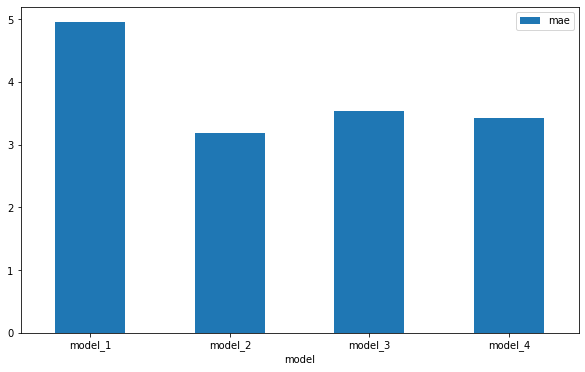

In [ ]:
model_results_df.plot(x="model",y="mae",kind="bar",figsize=(10,6))
plt.xticks(rotation="horizontal");

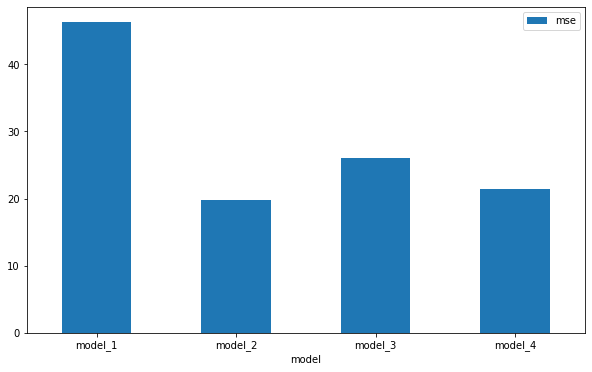

In [ ]:
model_results_df.plot(x="model",y="mse",kind="bar",figsize=(10,6))
plt.xticks(rotation="horizontal");